In [1]:
#
# Example of fitting A->B->C where measurements are for A and B/B+C
# https://github.com/salvadorgarciamunoz/kipet/blob/master/kipet/new_examples/Ex_17_custom_objective.py
#

In [32]:
from kipet import KipetModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
filename = '/home/paperspace/learn_kipet/my_data_sets/ABC_data.csv'
all_data = pd.read_csv(filename, index_col = 0)
all_data.columns = ['A', 'B', 'C']
all_data.head()

,A,B,C
t,,,
0.000,0.957,-0.031,-0.015
0.263,0.557,0.330,0.044
0.526,0.342,0.512,0.156
0.789,0.224,0.499,0.310
1.053,0.123,0.428,0.454


In [37]:
all_data['y'] = all_data['B'] / (all_data['B'] + all_data['C'])
Y_data = all_data[['y']]
C_data = all_data[['A']]

In [38]:
kipet_model = KipetModel()

r1 = kipet_model.new_reaction('rxn1')

r1.add_component('A', state = 'concentration', init = 1.0)
r1.add_component('B', state = 'concentration', init = 0.0)
r1.add_component('C', state = 'concentration', init = 0.0)

r1.add_parameter('k1', init = 5.0, bounds = (0.0, 10.0))
r1.add_parameter('k2', init = 5.0, bounds = (0.0, 10.0))

r1.add_algebraic_variables('y', init = 0.0, bounds = (0.0, 1.0))

def rule_odes(m, t):
    exprs = dict()
    exprs['A'] = -m.P['k1'] * m.Z[t,'A']
    exprs['B'] = m.P['k1'] * m.Z[t,'A'] - m.P['k2'] * m.Z[t,'B']
    exprs['C'] = m.P['k2'] * m.Z[t,'B']
    return exprs

r1.add_equations(rule_odes)

def rule_algebraics(m, t):
    r = list()
    r.append(m.Y[t,'y'] * (m.Z[t, 'B'] + m.Z[t, 'C']) - m.Z[t, 'B'])
    return r

r1.add_algebraics(rule_algebraics)

In [39]:
r1.add_dataset('C_data', category = 'concentration', data = C_data)
r1.add_dataset('y_data', category = 'custom', data = Y_data)

In [40]:
r1.add_objective_from_algebraic('y')

In [41]:
r1.settings.solver.linear_solver = 'ma27'
r1.run_opt()

Warning! Since Cm-matrix contains negative values Kipet is assuming a derivative of Cm has been inputted
0 5.0
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/param.py:640)
No variance information for A found, setting equal to unity
No variance information for B found, setting equal to unity
No variance information for C found, setting equal to unity
Ipopt 3.12: nlp_scaling_method=user-scaling
linear_solver=ma27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Ecl


RESULTS
Z:
                  A         B         C
0.000000  1.000000  0.000000  0.000000
0.010195  0.979555  0.020341  0.000103
0.042405  0.917664  0.080611  0.001726
0.065750  0.875267  0.120679  0.004054
0.075945  0.857373  0.137273  0.005354
...            ...       ...       ...
4.821811  0.000057  0.016510  0.983433
4.868500  0.000052  0.015770  0.984178
4.888889  0.000050  0.015458  0.984492
4.953311  0.000044  0.014510  0.985446
5.000000  0.000040  0.013859  0.986101

[151 rows x 3 columns]

Cm:
            A
0.000  0.957
0.263  0.557
0.526  0.342
0.789  0.224
1.053  0.123
1.316  0.079
1.579  0.035
1.842  0.029
2.105  0.025
2.368  0.017
2.632 -0.002
2.895  0.009
3.158 -0.023
3.421  0.006
3.684  0.016
3.947  0.014
4.211 -0.009
4.474 -0.030
4.737  0.004
5.000 -0.024

dZdt:
                  A         B         C
0.000000  0.000000  0.000000  0.000000
0.010195 -1.984824  1.964718  0.020107
0.042405 -1.859417  1.779736  0.079680
0.065750 -1.773511  1.654225  0.119286
0.075945 -1.7

In [42]:
r1.results.show_parameters


The estimated parameters are:
k1 2.026250351982965
k2 0.9884581428517176


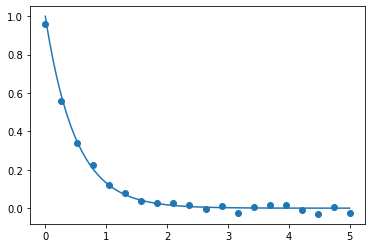

In [43]:
fig, ax = plt.subplots()
for c in ['A']:
    ax.scatter(r1.results.Cm.index, r1.results.Cm[c])
    ax.plot(r1.results.Z.index, r1.results.Z[c])

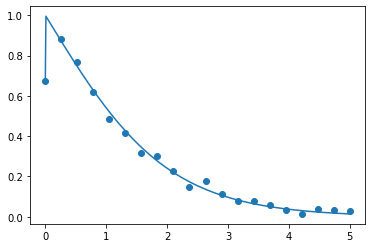

In [44]:
fig, ax = plt.subplots()
ax.scatter(Y_data.index, Y_data['y'])
ax.plot(r1.results.Y.index, r1.results.Y['y'])